# DCGAN MNIST

This notebook is for implementing `Deep Convolution Generative Adversarial Network(DCGAN)` from the paper [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434) with [Tensorflow](https://www.tensorflow.org). <br>
[MNIST data](http://yann.lecun.com/exdb/mnist/) will be used.

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import datetime
import os

## Parameters


In [3]:
algorithm = 'DCGAN_MNIST'

img_size   = 28

batch_size = 128
num_epoch  = 50

n_latent = 100

beta1 = 0.5

learning_rate_g = 0.0002
learning_rate_d = 0.0002

show_result_epoch = 5

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_DCGAN_MNIST/model/model" 

## Import MNIST Dataset

Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.

In [4]:
mnist = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [5]:
x_train = mnist[0][0]
y_train = mnist[0][1]
x_test  = mnist[1][0]
y_test  = mnist[1][1]

print('x_train shape: {}'.format(x_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('y_test shape: {}'.format(y_test.shape))

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


## Generator

In [6]:
def Generator(x, is_training, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()
        
        # Project and Reshape 
        w1 = tf.get_variable('w1', [x.get_shape()[1], 7*7*1024], initializer=xavier_init)
        b1 = tf.get_variable('b1', [7*7*1024], initializer=xavier_init)
        
        x_project = tf.matmul(x,w1)+b1
        x_reshape = tf.reshape(x_project, (-1, 7, 7, 1024))
        
        # First deconv layer
        h1 = tf.layers.conv2d_transpose(x_reshape,filters=512, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second deconv layer
        h2 = tf.layers.conv2d_transpose(h1,filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)  
        
        # Third deconv layer 
        h3 = tf.layers.conv2d_transpose(h2, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(h3, filters=1, kernel_size=5, strides=1, padding='SAME', kernel_initializer=xavier_init_conv)     
        output = tf.tanh(logits)
                
        return output

## Discriminator

In [7]:
def Discriminator(x, is_training, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        xavier_init_conv = tf.contrib.layers.xavier_initializer_conv2d()
        xavier_init = tf.contrib.layers.xavier_initializer()

        # First conv layer
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h2 = tf.layers.batch_normalization(h2, training=is_training)
        h2 = tf.nn.leaky_relu(h2)
        
        # Trhid conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=5, strides=2, padding='SAME', kernel_initializer=xavier_init_conv)
        h3 = tf.layers.batch_normalization(h3, training=is_training)
        h3 = tf.nn.leaky_relu(h3)
        
        # Output layer
        flatten = tf.reshape(h3, (-1, h3.get_shape()[1]*h3.get_shape()[2]*h3.get_shape()[3]))
        
        logit  = tf.layers.dense(flatten, 1, kernel_initializer=xavier_init)
        output = tf.sigmoid(logit)  

        return logit, output

## GAN

In [8]:
def GAN(x, z, is_training):
    # Generator
    G = Generator(z, is_training)
    
    # Discriminator
    D_logit_real, D_out_real = Discriminator(x, is_training)
    D_logit_fake, D_out_fake = Discriminator(G, is_training, reuse=True)
    
    # get loss
    d_loss = -(tf.reduce_mean(tf.log(D_out_real + 1e-8)) + tf.reduce_mean(tf.log( (1-D_out_fake) + 1e-8)))
    g_loss = -tf.reduce_mean(tf.log(D_out_fake + 1e-8))

    return d_loss, g_loss , G

## Build Graph

In [9]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 1])
x_normalize = (tf.cast(x, tf.float32) - (255.0/2)) / (255.0/2)

z = tf.placeholder(tf.float32, shape=[None, n_latent])

is_training = tf.placeholder(tf.bool)

d_loss, g_loss, G = GAN(x_normalize, z, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('Discriminator')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('Generator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(learning_rate_d).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(learning_rate_g).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [10]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [ ]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

Epoch: 1 / G Loss: 4.00108 / D Loss: 0.36782


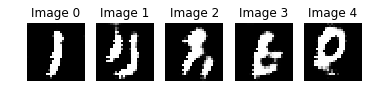

Epoch: 2 / G Loss: 7.86072 / D Loss: 0.82258
Epoch: 3 / G Loss: 5.03641 / D Loss: 0.26739
Epoch: 4 / G Loss: 3.41506 / D Loss: 0.61428
Epoch: 5 / G Loss: 4.99872 / D Loss: 0.27721


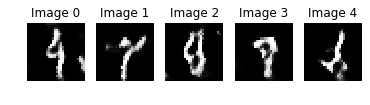

Epoch: 6 / G Loss: 3.89599 / D Loss: 0.24249
Epoch: 7 / G Loss: 4.26712 / D Loss: 0.30656
Epoch: 8 / G Loss: 2.75122 / D Loss: 0.50679
Epoch: 9 / G Loss: 1.84333 / D Loss: 0.59732
Epoch: 10 / G Loss: 2.23371 / D Loss: 0.32055


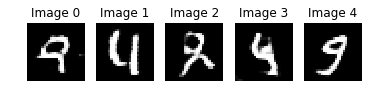

Epoch: 11 / G Loss: 4.12701 / D Loss: 0.19121
Epoch: 12 / G Loss: 3.41717 / D Loss: 0.44428
Epoch: 13 / G Loss: 3.43995 / D Loss: 0.24728
Epoch: 14 / G Loss: 3.05237 / D Loss: 0.45194
Epoch: 15 / G Loss: 3.06047 / D Loss: 0.37452


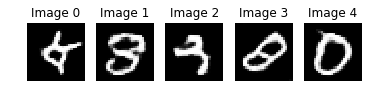

Epoch: 16 / G Loss: 1.85226 / D Loss: 0.58204
Epoch: 17 / G Loss: 2.56004 / D Loss: 0.65937
Epoch: 18 / G Loss: 2.86730 / D Loss: 0.38894
Epoch: 19 / G Loss: 2.26278 / D Loss: 0.53998
Epoch: 20 / G Loss: 2.91522 / D Loss: 0.37492


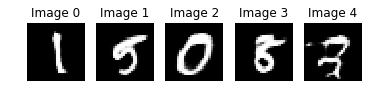

Epoch: 21 / G Loss: 2.20680 / D Loss: 0.63151
Epoch: 22 / G Loss: 2.55431 / D Loss: 0.79801
Epoch: 23 / G Loss: 1.83601 / D Loss: 0.55887
Epoch: 24 / G Loss: 2.97195 / D Loss: 0.41435
Epoch: 25 / G Loss: 2.60280 / D Loss: 0.57087


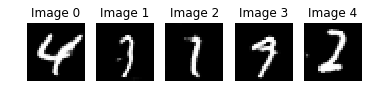

Epoch: 26 / G Loss: 1.78911 / D Loss: 0.62173
Epoch: 27 / G Loss: 2.36843 / D Loss: 0.60049
Epoch: 28 / G Loss: 2.47037 / D Loss: 0.65394
Epoch: 29 / G Loss: 2.70155 / D Loss: 0.43939
Epoch: 30 / G Loss: 2.69900 / D Loss: 0.48312


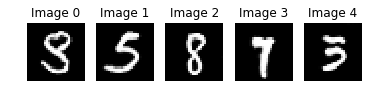

Epoch: 31 / G Loss: 2.60142 / D Loss: 0.32977
Epoch: 32 / G Loss: 2.16996 / D Loss: 0.93049
Epoch: 33 / G Loss: 2.01185 / D Loss: 0.46202
Epoch: 34 / G Loss: 2.55092 / D Loss: 0.44521
Epoch: 35 / G Loss: 1.80773 / D Loss: 0.77080


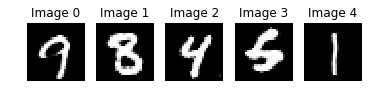

Epoch: 36 / G Loss: 2.50386 / D Loss: 0.64849
Epoch: 37 / G Loss: 3.03653 / D Loss: 0.41920
Epoch: 38 / G Loss: 2.80823 / D Loss: 0.38585
Epoch: 39 / G Loss: 1.68100 / D Loss: 0.43322
Epoch: 40 / G Loss: 2.21378 / D Loss: 0.90511


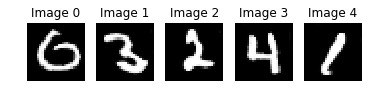

Epoch: 41 / G Loss: 1.26145 / D Loss: 0.55897
Epoch: 42 / G Loss: 1.74328 / D Loss: 0.62891
Epoch: 43 / G Loss: 3.26989 / D Loss: 0.35692
Epoch: 44 / G Loss: 2.11031 / D Loss: 0.40998
Epoch: 45 / G Loss: 3.39902 / D Loss: 0.39096


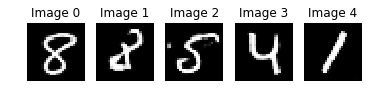

Epoch: 46 / G Loss: 2.13323 / D Loss: 0.49962
Epoch: 47 / G Loss: 2.54932 / D Loss: 1.08607
Epoch: 48 / G Loss: 1.94757 / D Loss: 0.41966
Epoch: 49 / G Loss: 2.51574 / D Loss: 0.30599
Epoch: 50 / G Loss: 3.09060 / D Loss: 0.39425


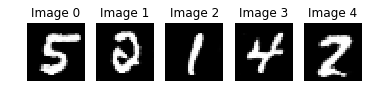

In [11]:
if train_model:
    # Training
    data_x = x_train
    len_data = x_train.shape[0]

    for i in range(num_epoch):
        # Shuffle the data 
        np.random.shuffle(data_x)

        # Making mini-batch
        for j in range(0, len_data, batch_size):
            if j + batch_size < len_data:
                data_x_in = data_x[j : j + batch_size, :]
            else:
                data_x_in = data_x[j : len_data, :]

            data_x_in = data_x_in.reshape((-1, img_size, img_size, 1))

            sampled_z = np.random.uniform(-1, 1, size=(data_x_in.shape[0] , n_latent))

            # Run Optimizer!
            G_out = sess.run(G, feed_dict = {x: data_x_in, z: sampled_z, is_training: True})

            _, loss_d = sess.run([train_step_d, d_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})
            _, loss_g = sess.run([train_step_g, g_loss], feed_dict = {x: data_x_in, z: sampled_z, is_training: True})

            print("Batch: {} / {}".format(j, len_data), end="\r")

        # Print Progess
        print("Epoch: {} / G Loss: {:.5f} / D Loss: {:.5f}".format((i+1), loss_g, loss_d))

        # Show test images 
        z_test = np.random.uniform(-1, 1, size=(5, n_latent))
        G_out = sess.run(G, feed_dict = {z: z_test, is_training: False})

        if i == 0 or (i+1) % show_result_epoch == 0:
            f, ax = plt.subplots(1,5)
            for j in range(5):
                ax[j].imshow(G_out[j,:,:,0], cmap = 'gray')
                ax[j].axis('off')
                ax[j].set_title('Image '+str(j))

        plt.show()

## Image Generation

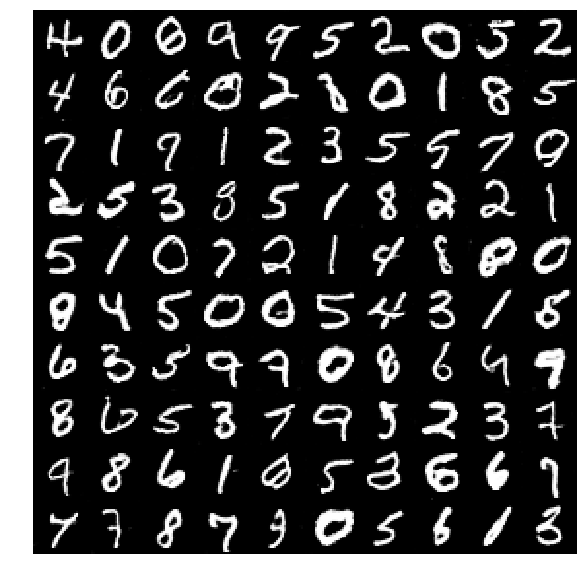

In [12]:
num_test = 10

img = np.zeros([img_size * num_test, img_size * num_test])

z_result = np.random.uniform(-1, 1, size=(num_test**2, n_latent))
G_result = sess.run(G, feed_dict = {z: z_result, is_training: False})

for i in range(num_test**2):
    row_num = int(i/num_test)
    col_num = int(i%num_test)
    
    img[row_num * img_size : (row_num + 1) * img_size, (col_num) * img_size : (col_num + 1) * img_size] = G_result[i,:,:,0]

plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Save Model

In [ ]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))